## Importing and prepping data

In [1]:
import pandas as pd
import numpy as np
import diff_classifier.aws as aws
import diff_classifier.pca as pca
import os

In [2]:
features = []
remote_folder = 'Gel_studies' #Folder in AWS S3 containing files to be analyzed
bucket = 'dtoghani.data'
vids = 10
mws = ['5k_PEG', 'PS_COOH', '5k_PEG_NH2', 'PS_NH2']
nonnum = ['Particle Type', 'Video Number', 'Track_ID', 'Deff2',
          'Mean Mean_Intensity', 'Std Mean_Intensity',
          'X', 'Y', 'Mean X', 'Mean Y', 'Std X', 'Std Y']
calcs = [2]

counter = 0
for calc in calcs:
    for mw in mws:
        for num in range(1, vids+1):
            try:
                filename = 'features_{}_{}mM_XY{}.csv'.format(mw, calc, '%02d' % num)
                #os.remove(filename)
                aws.download_s3('{}/{}'.format(remote_folder, filename), filename, bucket_name=bucket)
                fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
                fstats['Particle Type'] = pd.Series(fstats.shape[0]*[mw], index=fstats.index)
                fstats['Video Number'] = pd.Series(fstats.shape[0]*[num], index=fstats.index)
                #fstats['Calcium Concentration'] = pd.Series(fstats.shape[0]*[str(calcs)], index=fstats.index)
                #print(num)
                print(filename)
                counter = counter + 1
                if counter == 1:
                    fstats_tot = fstats
                else:
                    fstats_tot = fstats_tot.append(fstats, ignore_index=True)
            except:
                print('skip filename: {}'.format(filename))

features_5k_PEG_2mM_XY01.csv
features_5k_PEG_2mM_XY02.csv
features_5k_PEG_2mM_XY03.csv
features_5k_PEG_2mM_XY04.csv
features_5k_PEG_2mM_XY05.csv
features_5k_PEG_2mM_XY06.csv
features_5k_PEG_2mM_XY07.csv
features_5k_PEG_2mM_XY08.csv
features_5k_PEG_2mM_XY09.csv
features_5k_PEG_2mM_XY10.csv
features_PS_COOH_2mM_XY01.csv
features_PS_COOH_2mM_XY02.csv
features_PS_COOH_2mM_XY03.csv
features_PS_COOH_2mM_XY04.csv
features_PS_COOH_2mM_XY05.csv
features_PS_COOH_2mM_XY06.csv
features_PS_COOH_2mM_XY07.csv
features_PS_COOH_2mM_XY08.csv
skip filename: features_PS_COOH_2mM_XY09.csv
features_PS_COOH_2mM_XY10.csv
features_5k_PEG_NH2_2mM_XY01.csv
features_5k_PEG_NH2_2mM_XY02.csv
features_5k_PEG_NH2_2mM_XY03.csv
features_5k_PEG_NH2_2mM_XY04.csv
features_5k_PEG_NH2_2mM_XY05.csv
features_5k_PEG_NH2_2mM_XY06.csv
features_5k_PEG_NH2_2mM_XY07.csv
features_5k_PEG_NH2_2mM_XY08.csv
features_5k_PEG_NH2_2mM_XY09.csv
features_5k_PEG_NH2_2mM_XY10.csv
features_PS_NH2_2mM_XY01.csv
features_PS_NH2_2mM_XY02.csv
feature

In [3]:
nonnum = ['Particle Type', 'Video Number', 'Track_ID', 'Mean Mean_Intensity', 'Std Mean_Intensity', 'X', 'Y', 'Quality',
          'Mean_Intensity', 'SN_Ratio', 'Mean X', 'Std X', 'Mean Y', 'Std Y', 'Mean Quality', 'Std Quality', 'Mean SN_Ratio',
          'Std SN_Ratio', 'binx', 'biny', 'bins']

## Train-Test Split

In [4]:
bins = list(range(0, 2048+1, 256))
fstats_tot['binx'] = pd.cut(fstats_tot.X, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7])
fstats_tot['biny'] = pd.cut(fstats_tot.Y, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7])
fstats_tot['bins'] = 8*fstats_tot['binx'] + fstats_tot['biny']
fstats_tot = fstats_tot[np.isfinite(fstats_tot.bins)]
fstats_tot.bins = fstats_tot.bins.astype(int)

In [5]:
# cols = fstats_tot.columns.tolist()
# cols = cols[-3:] + cols[:-3]
# pcadataset.final = pcadataset.final[cols]

def checkerboard(size):
    rows = int(size/2)
    checks = list(range(0, size*size, size+1))
    
    for i in range(1, rows):
        ssize = size - 2*i
        for j in range(0, ssize):
            checks.append(2*i + (size+1)*j)

    for i in range(1, rows):
        ssize = size - 2*i
        for j in range(0, ssize):
            checks.append(size*size - 1 - (2*i + (size+1)*j))
    checks.sort()
    return checks

In [6]:
featofvar = 'Particle Type'
#ncomp = 15

# X_train = pcadataset.final[pcadataset.final.bins.isin(checkerboard(8))].values[:, -ncomp:]
# X_test = pcadataset.final[~pcadataset.final.bins.isin(checkerboard(8))].values[:, -ncomp:]
# y_train = pcadataset.final[pcadataset.final.bins.isin(checkerboard(8))][featofvar].values
# y_test = pcadataset.final[~pcadataset.final.bins.isin(checkerboard(8))][featofvar].values

f_train = fstats_tot[fstats_tot.bins.isin(checkerboard(8))].reset_index()
f_test = fstats_tot[~fstats_tot.bins.isin(checkerboard(8))].reset_index()

# for run in range(1):
#     clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
#                         alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
#                         early_stopping=True, validation_fraction=0.1)

#     clf.fit(X_train, y_train)
    
#     print('Training Results')
#     y_true1, y_pred1 = y_train, clf.predict(X_train)
#     print(classification_report(y_true1, y_pred1, digits=4))
    
#     print('Test Results')
#     print()
#     y_true, y_pred = y_test, clf.predict(X_test)
#     print(classification_report(y_true, y_pred, digits=4))

In [7]:
f_train.shape

(794564, 73)

## PCA analysis

The pca.pca_analysis function provides a completely contained PCA analysis of the input trajectory features dataset. It includes options to impute NaN values (fill in with average values or drop them), and to scale features. Read the docstring for more information. 

In [8]:
ncomp = 13
pca_train = pca.pca_analysis(f_train, dropcols=nonnum, n_components=ncomp)

Cumulative explained variance:
0 component: 0.21510646270054007
1 component: 0.3673031784438223
2 component: 0.4694565801550783
3 component: 0.5251079818129146
4 component: 0.5763231890788094
5 component: 0.6220191652450615
6 component: 0.6617460722913382
7 component: 0.6975238874111749
8 component: 0.7291634766221468
9 component: 0.7566274120015238
10 component: 0.7808870725888833
11 component: 0.7999256342521335
12 component: 0.8175890831141455


The pca.kmo function calculates the Kaiser-Meyer-Olkin statistic, a measure of sampling adequacy. Check the docstring for more information.

In [9]:
kmostat = pca.kmo(pca_train.scaled)

0.869456868104


In [10]:
pca_train.final.head()

,index,Track_ID,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,asymmetry3,AR,elongation,...,3,4,5,6,7,8,9,10,11,12
0,2,2.0,6.161304e-08,0.103930,3.789870,0.108738,0.709955,0.014490,1.485250,0.326713,...,2.755437,-0.301442,4.001731,1.518523,0.435210,-1.381743,-0.584547,1.996383,-0.043404,3.153411
1,3,3.0,1.027589e+00,0.266434,2.183024,0.813975,0.226740,0.221473,1.779302,0.437982,...,3.936270,2.835308,-1.117270,0.853174,-1.320495,0.514090,-2.161841,-0.881856,0.541485,-1.903549
2,6,6.0,8.768778e-01,0.713197,3.700716,0.987078,0.057023,0.507376,2.524342,0.603857,...,2.220904,0.143708,2.436450,1.803640,2.782862,0.490272,-0.867239,2.231043,0.799352,3.389147
3,8,8.0,2.811978e+00,0.000022,4.551733,0.665190,0.318699,0.143249,1.792872,0.442236,...,3.490848,5.823225,-2.439287,2.169443,0.305611,0.328166,0.249515,-1.260920,-1.081611,-0.470607
4,12,12.0,1.674882e-02,0.128939,2.615646,0.291322,0.546735,0.043887,1.422944,0.297232,...,4.224730,4.519831,-3.409590,-0.015038,3.595645,-0.133572,-2.039904,-0.617175,0.069644,-3.842241


In [11]:
pca_test = pca.pca_analysis(f_test, dropcols=nonnum, n_components=ncomp, existing_model=True, model_file=pca_train)

## Visualization

Users can then compare average principle component values between subgroups of the data. In this case, all particles were taken from the same sample, so there are no experimental subgroups. I chose to compare short trajectories to long trajectories, as I would expect differences between the two groups.

In [18]:
import numpy as np
#ncomp = 10
dicti = {}
#test = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==200].as_matrix()), axis=0))[-6:]
#test1 = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==500].as_matrix()), axis=0))[-6:]
dicti[0] = np.nanmean(pca_train.final[pca_train.final['Particle Type']=='5k_PEG'].values[:, -ncomp:], axis=0)
dicti[1] = np.nanmean(pca_train.final[pca_train.final['Particle Type']=='5k_PEG_NH2'].values[:, -ncomp:], axis=0)
dicti[2] = np.nanmean(pca_train.final[pca_train.final['Particle Type']=='PS_COOH'].values[:, -ncomp:], axis=0)
dicti[3] = np.nanmean(pca_train.final[pca_train.final['Particle Type']=='PS_NH2'].values[:, -ncomp:], axis=0)

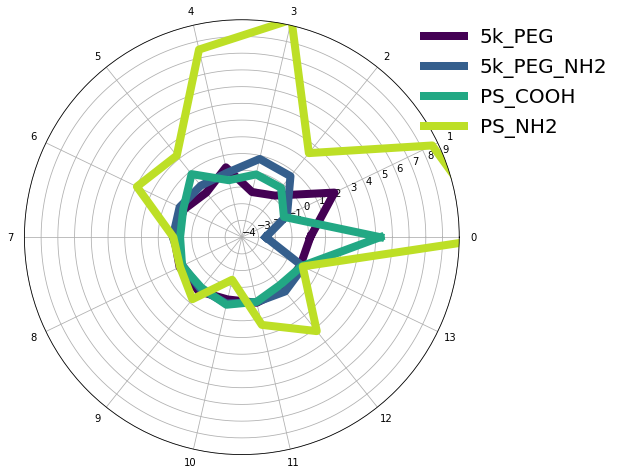

In [21]:
labels = mws
pca.plot_pca(dicti, savefig=True, labels=labels, rticks=np.linspace(-4, 9, 14), filename='pics/surfacefunc_pcaavg.png')

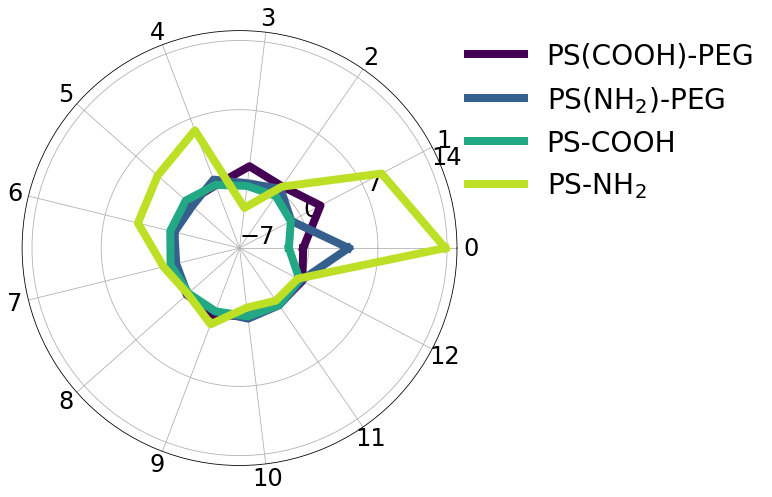

In [26]:
labels = ['5k_PEG', '5k_PEG_NH2', 'PS_COOH', 'PS_NH2']
labels2 = ['PS(COOH)-PEG', r'PS(NH$_{2}$)-PEG', 'PS-COOH', r'PS-NH$_{2}$']
pca.plot_pca(dicti, savefig=True, labels=labels2, rticks=np.linspace(-7, 14, 4), dpi=1200, labelsize=24,
             filename='pics/sf2_pcaavg.png')

The variable pcadataset.prcomps shows the user the major contributions to each of the new principle components. When observing the graph above, users can see that there are some differences between short trajectories and long trajectories in component 0 (asymmetry1 being the major contributor) and component 1 (elongation being the major contributor).

In [27]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns
def feature_violin(df, label='label', lvals=['yes', 'no'], fsubset=3, **kwargs):
    """Creates violinplot of input feature dataset

    Designed to plot PCA components from pca_analysis.

    Parameters
    ----------
    df : pandas.core.frames.DataFrame
        Must contain a group name column, and numerical feature columns.
    label : string or int
        Name of group column.
    lvals : list of string or int
        All values that group column can take
    fsubset : int or list of int
        Features to be plotted. If integer, will plot range(fsubset).
        If list, will only plot features contained in fsubset.
    **kwargs : variable
        figsize : tuple of int or float
            Dimensions of output figure
        yrange : list of int or float
            Range of y axis
        xlabel : string
            Label of x axis
        labelsize : int or float
            Font size of x label
        ticksize : int or float
            Font size of y tick labels
        fname : None or string
            Name of output file
        legendfontsize : int or float
            Font size of legend
        legendloc : int
            Location of legend in plot e.g. 1, 2, 3, 4

    """

    defaults = {'figsize': (12, 5), 'yrange': [-20, 20], 'xlabel': 'Feature',
                'labelsize': 20, 'ticksize': 16, 'fname': None,
                'legendfontsize': 12, 'legendloc': 1}

    for defkey in defaults.keys():
        if defkey not in kwargs.keys():
            kwargs[defkey] = defaults[defkey]

    # Restacking input data
    groupsize = []
    featcol = []
    valcol = []
    feattype = []

    if isinstance(fsubset, int):
        frange = range(fsubset)
    else:
        frange = fsubset

    for feat in frange:
        groupsize.extend(df[label].values)
        featcol.extend([feat]*df[label].values.shape[0])
        valcol.extend(df[feat].values)

    to_violind = {'label': groupsize, 'Feature': featcol,
                  'Feature Value': valcol}
    to_violin = pd.DataFrame(data=to_violind)

    # Plotting function
    fig, ax = plt.subplots(figsize=kwargs['figsize'])
    sns.violinplot(x="Feature", y="Feature Value", hue="label", data=to_violin,
                   palette=cm.viridis(np.linspace(0, 0.9, 4)), hue_order=lvals,
                   figsize=kwargs['figsize'], linewidth=0)

    # kwargs
    ax.tick_params(axis='both', which='major', labelsize=kwargs['ticksize'])
    plt.xlabel('Feature', fontsize=kwargs['labelsize'])
    plt.ylabel('Normalized\nFeature Space', fontsize=kwargs['labelsize'])
    plt.ylim(kwargs['yrange'])
    plt.legend(loc=kwargs['legendloc'], prop={'size': kwargs['legendfontsize']})
    plt.setp(ax.collections, alpha=.75)
    if kwargs['fname'] is None:
        plt.show()
    else:
        plt.savefig(kwargs['fname'], dpi=1200, pad_inches=0.22)

    return to_violin

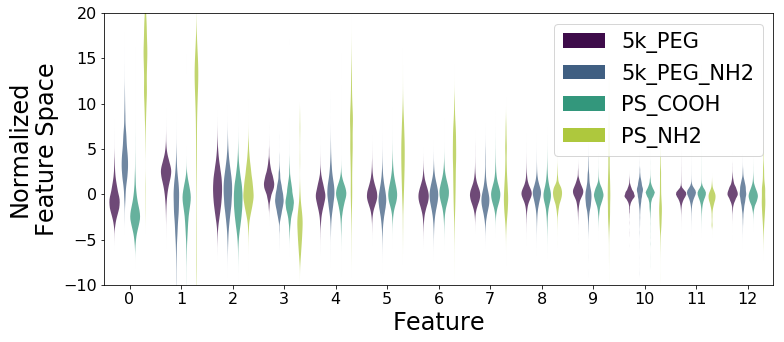

In [29]:
feats = feature_violin(pca_train.final, label='Particle Type', lvals=labels, labels=labels2, fsubset=ncomp, yrange=[-10, 20],
                       legendfontsize=21, labelsize=24, fname='./pics/sf2_pcadist.png')

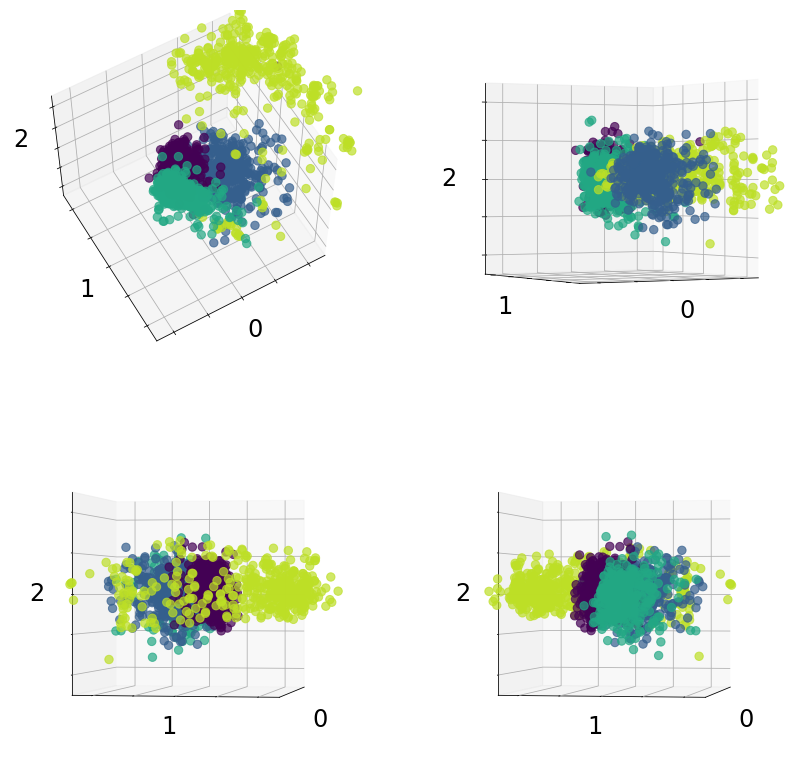

In [33]:
fstats1 = pca.feature_plot_3D(pca_train.final, label='Particle Type', lvals=labels, randcount=400, ylim=[-12, 12],
                              xlim=[-12, 12], zlim=[-12, 12], legendfontsize=24, labelfontsize=24, dpi=1600,
                              ticksize=20,
                              fname='./pics/sf2_3feats.png')

## Neural Network

In [31]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

In [32]:
X_train = pca_train.final.values[:, -ncomp:]
X_test = pca_test.final.values[:, -ncomp:]
y_train = pca_train.final[featofvar].values
y_test = pca_test.final[featofvar].values

for run in range(1):
    clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)

    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))

    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.09669898
Validation score: 0.975710
Iteration 2, loss = 0.06779665
Validation score: 0.981663
Iteration 3, loss = 0.05359496
Validation score: 0.984872
Iteration 4, loss = 0.04198119
Validation score: 0.991606
Iteration 5, loss = 0.03281926
Validation score: 0.992638
Iteration 6, loss = 0.02614038
Validation score: 0.994551
Iteration 7, loss = 0.02152774
Validation score: 0.996803
Iteration 8, loss = 0.01830025
Validation score: 0.997080
Iteration 9, loss = 0.01616902
Validation score: 0.998188
Iteration 10, loss = 0.01454680
Validation score: 0.998477
Iteration 11, loss = 0.01348331
Validation score: 0.998150
Iteration 12, loss = 0.01284949
Validation score: 0.999044
Iteration 13, loss = 0.01218157
Validation score: 0.999044
Iteration 14, loss = 0.01167999
Validation score: 0.998817
Iteration 15, loss = 0.01144815
Validation score: 0.998930
Validation score did not improve more than tol=0.000010 for two consecutive epochs. Setting learning rate to 0.001000
Iterat